In [ ]:
%pip install emoji
%pip install wordcloud

In [2]:
import nltk
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mat
import seaborn as sns
plt.style.use('ggplot')

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.util import ngrams
from nltk.tokenize import RegexpTokenizer

from sklearn.feature_extraction import text 
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.decomposition import LatentDirichletAllocation, PCA, IncrementalPCA, TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.mixture import GaussianMixture

from scipy.sparse import random as sparse_random

import re
from collections import Counter
import emoji
from wordcloud import WordCloud
import pickle
import bz2

import time
from datetime import datetime as dt

In [ ]:
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

# load csv and pickles here 

In [3]:
main_posts_date_reduced = pd.read_csv('../data/main_posts_dates_reduced.csv')

In [6]:
infile = open('../pickles/corpus_reduced', 'rb')
corpus_reduced = pickle.load(infile)
infile.close()

# Main Functions

In [4]:
# several of the processing functions were copied from the NLP lecture


# the toked function:
# removes newline characters
# removes apostrophes, easier to just remove apostrophes and leave naked contractions rather than expand them
    # there's only like what a handful of common contractions, they can be words for this as far as i'm concerned
# removes links that have the format 'https://etc'
# removes special characters
# replaces any number in the string with num
# returns this split stripped and joined back together to remove multiple blanks
# runs this through the nltk RegexTokenizer modified to handle emojis, which splits individual emojis
    # so that three rocketships is 3 occurrences of one rocketship, etc. instead of its own separate character
# finally translates emojis from their emoji symbol to a word representation of it so that ngrams captures these
tokenizer = RegexpTokenizer(r'\w+|[^\w\s]')
link_regex = re.compile(r'(https://)[a-z./0-9?=&;-]*')
numbers = re.compile(r'([0-9],?)+')
apostrophe = re.compile(r"\'|’") # heads up for both versions of the apostrophe!! dammit ' and ’
newline = re.compile(r'(\\n)')
specials = re.compile(r'[-+~`:;@=\'’"”#“$|,%/&^•·)(\]\[\*\\?!\._]')
def toked(doc):
    modified = newline.sub(' ', doc)
    modified = apostrophe.sub('', modified)
    modified = link_regex.sub('', modified)
    modified = specials.sub('', modified)
    modified = numbers.sub('', modified)
    modified = ' '.join(modified.split()).strip()
    modified = tokenizer.tokenize(modified)
    
    translated = []
    for word in modified:
        if word in emoji.UNICODE_EMOJI_ENGLISH:
            translated.append('emoji_' + emoji.UNICODE_EMOJI_ENGLISH[word])
        else:
            translated.append(word)
    
    translated = ' '.join(translated)
    modified = ' '.join(specials.sub('', translated).split()).strip()
            
    return modified


# lemmatize
def lemmatize(doc):
    # get the words in the document
    words = re.findall("\w+|[^\w\s]", doc)
    # get the parts of speech
    pos_tokens = nltk.pos_tag(words)
    
    # process_word(*token) uses star args to supply both word and part of speech to process_word
    # for token in pos_tokens - we want to do this for every token in the document
    
    return ' '.join([process_word(*token) for token in pos_tokens])


def process_word(word, pos):
    lemmatizer = WordNetLemmatizer()
    pos_dict = {'J':'a', 'V':'v', 'N':'n', 'R': 'r'}
    if pos[0] in pos_dict:
        return lemmatizer.lemmatize(word.lower(), pos_dict[pos[0]])
    else:
        return lemmatizer.lemmatize(word.lower())
    

# extract n-grams
def get_ngrams(doc):
    # build vectorizer and analyzer
    vectorizer = CountVectorizer(ngram_range=(2, 2), preprocessor=None, tokenizer=None).build_analyzer()
    # return the n-grams of size 2 and 3 without stop words in this case
    return vectorizer(doc, stop_words=stopwords.words('english'))


# remove stopwords
my_additional_stop_words =  ('im', '', 'ud', 'u', 'pc', 'ampxb', 'unum', 'numc', 'unuma', 'unumd', 'num', 'numm', 'numk', 'xnumb', 'amp', 'im', 'ampxnumb', 'numlt', 'numnd', "ampxnumb")
stop_words = text.ENGLISH_STOP_WORDS.union(my_additional_stop_words)
real_words = ''
def remove_stop_words(words):
#     words_split = words.split()
#     for word in words.split
    return [word for word in words.split() if word not in stop_words]

In [5]:
# full processing workflow, removing stop words before generating ngrams
# actually i ended up not using ngrams in my model due to needing to save space in the amount 
# in the amount of additional text that generated

def processing(doc):
    tokens = toked(str(doc)) # returns a string
    words = lemmatize(tokens) # returns a string
    words = remove_stop_words(words) # returns a list
#     ngrams = get_ngrams(' '.join(words)) # returns a list
    return words #+ ngrams # returns a list of lists of words and ngrams

# Generate Corpus

need to load in the pickles for main_posts_date_reduced or main_comments_date_reduced

In [ ]:
# reduced corpus between jan 22 and jan 31
%%time

corpus_reduced = []
for i in range(len(main_posts_dates_reduced)):
    corpus_reduced.append([main_posts_dates_reduced.selftext.iloc[i]])

# Processing Text and Generating Topics with LDA

In [7]:
%%time
t0 = time.time()

# the output from processed reduced is a list of tokens that is passed into count vectorizer
# no ngrams are generated in count vectorizer to save memory space

processed_reduced = []
for doc in corpus_reduced:
    processed_reduced.append(processing(doc))

    
t1 = time.time()
print('time elapsed for corpus processing: ' + str(time.strftime('%M:%S', time.localtime(t1 - t0))) + '\n')


vectorizer = CountVectorizer(stop_words=None, 
                             max_df=0.8, 
                             min_df=4, 
                             max_features=2000,
                             tokenizer=None,
                             lowercase=False, 
                             preprocessor=None,
                             analyzer=lambda x: x)
#                              ngram_range=(1,3))

X = vectorizer.fit_transform(processed_reduced)
features = vectorizer.get_feature_names()


t2 = time.time()
print('time elapsed for count vectorizer: ' + str(time.strftime('%M:%S', time.localtime(t2 - t1))) + '\n')


lda = LatentDirichletAllocation(n_components=7, random_state=42, learning_method='online', n_jobs=-1)
lda.fit(X)
print(lda.components_.shape)
top_components = lda.components_.argsort()[:,-1:-11:-1]

# top_components.shape
for i, v in enumerate(top_components):
    print(i, [features[i] for i in v])
    
    
t3 = time.time()
print('\n' + 'time elapsed for LDA model: ' + str(time.strftime('%M:%S', time.localtime(t3 - t2))) + '\n')

time elapsed for corpus processing: 02:07

time elapsed for count vectorizer: 00:00

(7, 2000)
0 ['company', 'platform', 'market', 'year', 'nokia', 'new', 'business', 'user', 'million', 'good']
1 ['emojirocket', 'emojigemstone', 'emojiraisinghands', 'moon', 'hold', 'gme', 'emojiopenhands', 'let', 'emojifullmoon', 'emojiraisedhand']
2 ['amc', 'delete', 'buy', 'bb', 'gme', 'moon', 'pump', 'emojigorilla', 'sndl', 'doge']
3 ['robinhood', 'buy', 'stock', 'trade', 'market', 'trading', 'account', 'gme', 'order', 'broker']
4 ['let', 'nok', 'stop', 'brokerage', 'dont', 'happen', 'watch', 'win', 'fight', 'gonna']
5 ['hold', 'fuck', 'just', 'buy', 'gme', 'dont', 'like', 'stock', 'make', 'money']
6 ['short', 'share', 'price', 'fund', 'hedge', 'sell', 'squeeze', 'gme', 'position', 'stock']

time elapsed for LDA model: 01:13

CPU times: user 2min 57s, sys: 10.1 s, total: 3min 7s
Wall time: 3min 21s


# Scale the Data from CountVectorizer above

In [8]:
# perform standard scaler on count vectorizer array

scaler = StandardScaler(with_mean = False)
scaled = scaler.fit_transform(X)

# TF * IDF Vectorizer

In [17]:
%%time

tf_idf_vectorizer = TfidfVectorizer(lowercase=False, analyzer= lambda x: x, ngram_range=(1,3) )
tf_idf = tf_idf_vectorizer.fit_transform(processed_reduced)
tf_idf_norm = normalize(tf_idf)
tf_idf_array = tf_idf_norm.toarray()

CPU times: user 1.28 s, sys: 818 ms, total: 2.1 s
Wall time: 2.11 s


In [19]:
tf_scaler = StandardScaler(with_mean=False)
tf_scaled = tf_scaler.fit_transform(tf_idf_array)

# KMeans Clustering, 3 Clusters, on scaled Count Vectorizer array

In [9]:
trunc_svd = TruncatedSVD(n_components=2)
y_trunc_svd = trunc_svd.fit_transform(scaled) # passing in count vectorizer scaled data

kmeans = KMeans(n_clusters=3, max_iter = 1000, algorithm = 'auto') # clustering model with 3 clusters

fitted = kmeans.fit(y_trunc_svd) # fit the kmeans clusters

In [10]:
prediction = kmeans.predict(y_trunc_svd)

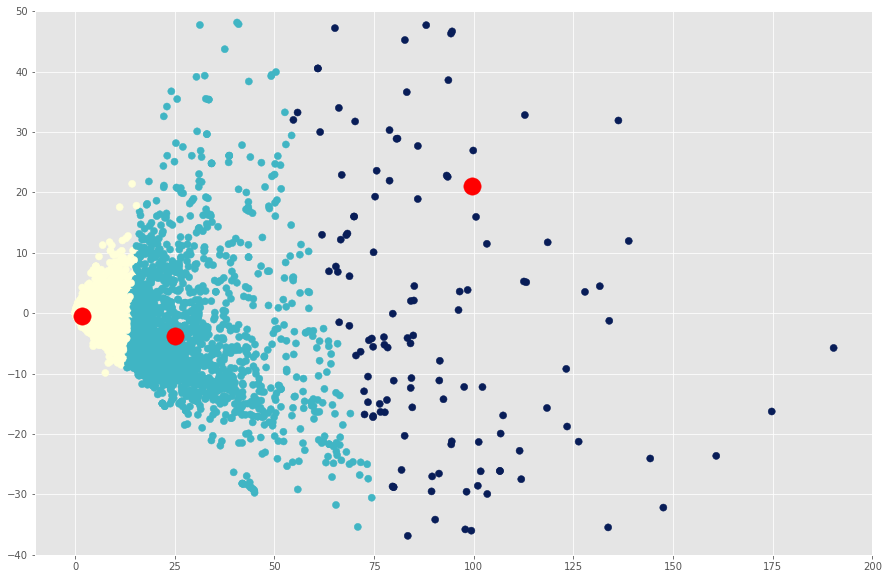

In [121]:
fig, ax = plt.subplots(figsize = (15,10))
plt.scatter(y_trunc_svd[:, 0], y_trunc_svd[:, 1],c=prediction ,s=50, cmap='YlGnBu')
centers = fitted.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1],c='red', s=300, alpha=1)
plt.xlim(-10, 200)
plt.ylim(-40, 50);
plt.savefig('../images/clustering_plot.png')

some colormap options

'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'

In [12]:
centers

array([[ 1.63743505, -0.49550087],
       [25.05762112, -3.70605176],
       [99.50260358, 21.12347637]])

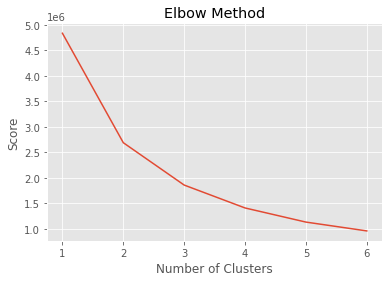

In [13]:
number_clusters = range(1, 7)

kmeans = [KMeans(n_clusters=i, max_iter = 600) for i in number_clusters]
kmeans

score = [kmeans[i].fit(y_trunc_svd).score(y_trunc_svd) for i in range(len(kmeans))]
score = [i*-1 for i in score]

plt.plot(number_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Method')
plt.show()

In [14]:
# function for extracting top features from each cluster

def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = tf_idf_vectorizer.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs


In [20]:
dfs = get_top_features_cluster(tf_scaled, prediction, 20)

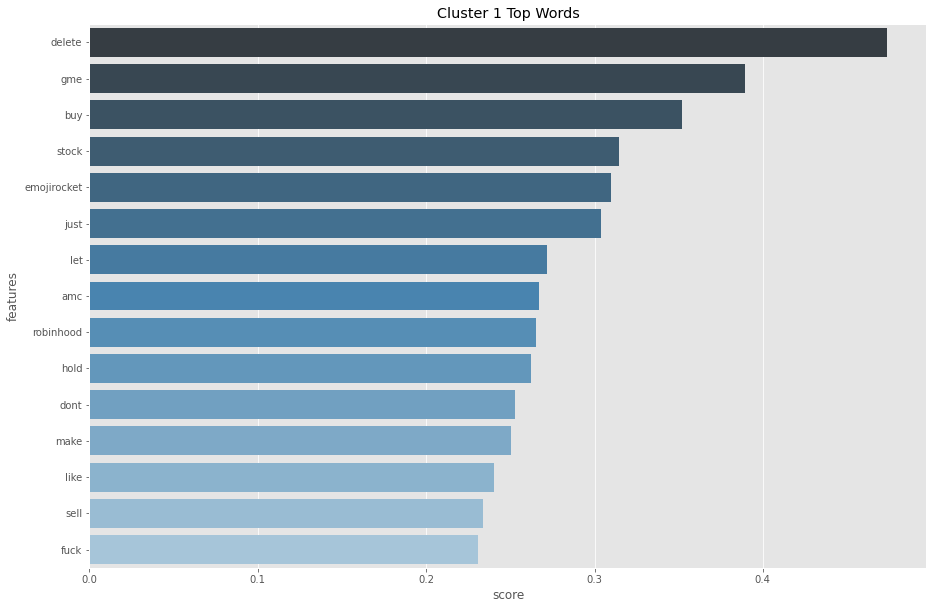

In [39]:
fig, ax = plt.subplots(figsize=(15,10))
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[0][:15], palette='Blues_d')
ax.set_title('Cluster 1 Top Words')
plt.savefig('../images/posts_cluster1_topwords_barplot');

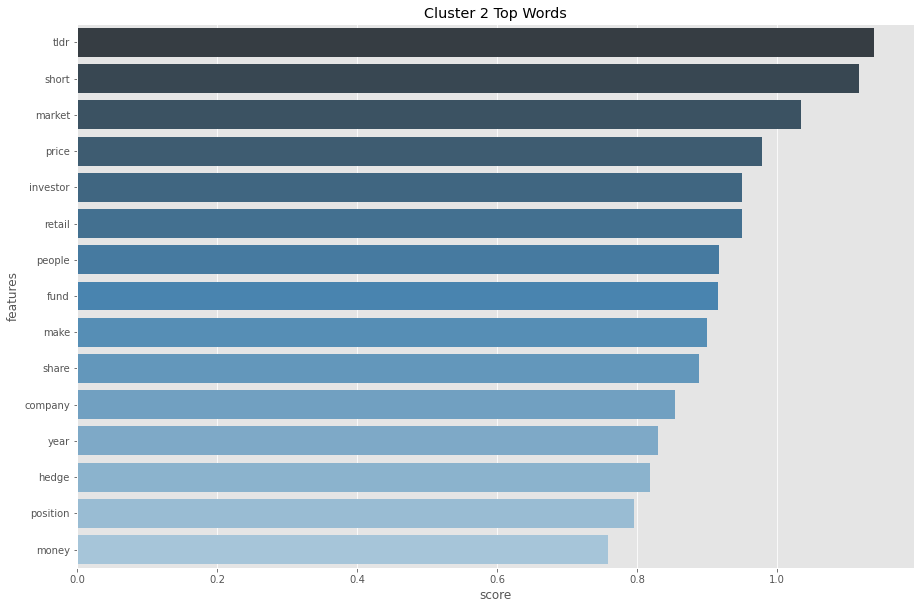

In [40]:
fig, ax = plt.subplots(figsize=(15,10))
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[1][:15], palette='Blues_d')
ax.set_title('Cluster 2 Top Words');

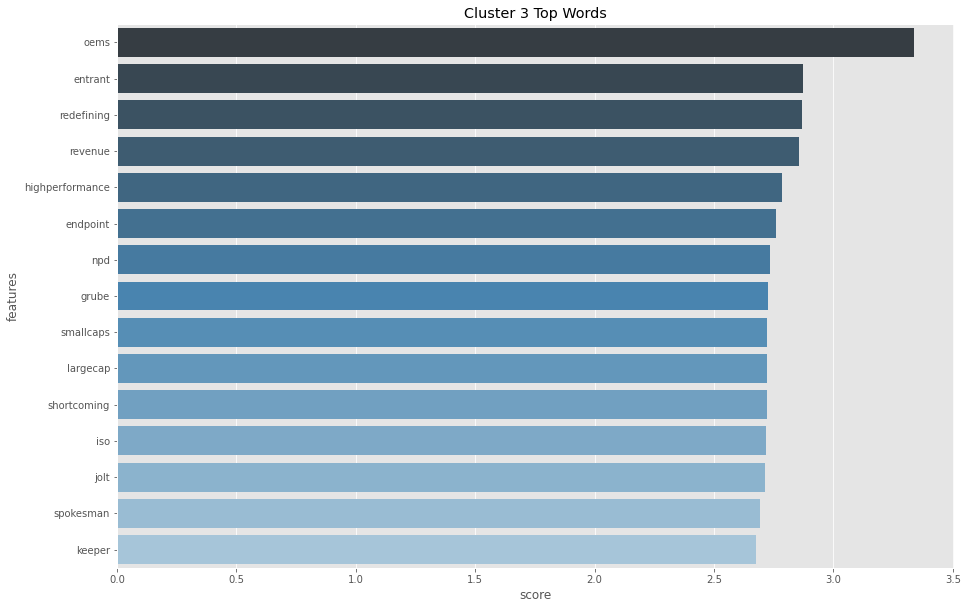

In [41]:
fig, ax = plt.subplots(figsize=(15,10))
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[2][:15], palette='Blues_d')
ax.set_title('Cluster 3 Top Words');

# Gaussian Mixture Modeling Clustering

In [ ]:
%%time

gm_cv = GaussianMixture(n_components=3, random_state=42)
dense_cv = scaler_cv_scaled.toarray()
gm_cv.fit_predict(dense_cv)